# Pre-prequisites

In [2]:
# Installing libraries

!pip install transformers

In [4]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import nltk
import torch
import json
import string
import re
from transformers import AutoTokenizer, AdamW, BertForQuestionAnswering, BertConfig
from torch.utils.data import DataLoader
from nltk.corpus import stopwords

In [8]:
# Exploring the dataset

# print(answers[each])
# print(answer_start[each])
# print(len(answer_end))
# print(squad_df_train['context'].values.tolist()[1])
# model.config

# Loading the train and validation datasets

In [4]:
# Loading the train dataset

with open('/kaggle/input/squad-files/train-v1.1.json', 'rb') as f:
  squad_dict_train = json.load(f)

squad_data = []
for article in squad_dict_train['data']:
  for paragraph in article['paragraphs']:
    for qa in paragraph['qas']:
      squad_data.append({'id': qa['id'],
                        'context': paragraph['context'],
                        'question': qa['question'],
                        'answer_text': qa['answers'][0]['text'],
                        'answer_start': qa['answers'][0]['answer_start']
                      })
squad_df_train = pd.DataFrame(squad_data)
squad_df_train.head()

,id,context,question,answer_text,answer_start
0,5733be284776f41900661182,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515
1,5733be284776f4190066117f,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188
2,5733be284776f41900661180,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279
3,5733be284776f41900661181,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381
4,5733be284776f4190066117e,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92


In [5]:
# Loading the validation dataset

with open('/kaggle/input/squad-files/dev-v1.1.json', 'rb') as f:
  squad_dict_valid = json.load(f)

squad_data = []
for article in squad_dict_valid['data']:
  for paragraph in article['paragraphs']:
    for qa in paragraph['qas']:
      squad_data.append({'id': qa['id'],
                        'context': paragraph['context'],
                        'question': qa['question'],
                        'answer_text': qa['answers'][0]['text'],
                        'answer_start': qa['answers'][0]['answer_start']
                      })
squad_df_valid = pd.DataFrame(squad_data)
squad_df_valid.head()

,id,context,question,answer_text,answer_start
0,56be4db0acb8001400a502ec,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,Denver Broncos,177
1,56be4db0acb8001400a502ed,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,249
2,56be4db0acb8001400a502ee,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"Santa Clara, California",403
3,56be4db0acb8001400a502ef,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,Denver Broncos,177
4,56be4db0acb8001400a502f0,Super Bowl 50 was an American football game to...,What color was used to emphasize the 50th anni...,gold,488


In [6]:
# Lengths of the datasets

print('Train:', squad_df_train.shape)
print('Validation:', squad_df_valid.shape)

Train: (87599, 5)
Validation: (10570, 5)


# Pre-processing

In [7]:
# Finding the answer end index for train answers

end_idxs = []
new_start_idxs = []
start_idxs = squad_df_train['answer_start'].values.tolist()
answer_texts = squad_df_train['answer_text'].values.tolist()
contexts = squad_df_train['context'].values.tolist()

for start, answer, context in zip(start_idxs, answer_texts, contexts):
  end = start + len(answer)
  if context[start: end] == answer:
    new_start_idxs.append(start)
    end_idxs.append(end)
  elif context[start - 1: end - 1] == answer:
    new_start_idxs.append(start - 1)
    end_idxs.append(end - 1)
  elif context[start - 2: end - 2] == answer:
    new_start_idxs.append(start - 2)
    end_idxs.append(end - 2)

squad_df_train['new_answer_start'] = new_start_idxs
squad_df_train['answer_end'] = end_idxs
squad_df_train.head()

,id,context,question,answer_text,answer_start,new_answer_start,answer_end
0,5733be284776f41900661182,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515,515,541
1,5733be284776f4190066117f,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188,188,213
2,5733be284776f41900661180,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,279,296
3,5733be284776f41900661181,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381,381,420
4,5733be284776f4190066117e,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92,92,126


In [8]:
# Finding the answer end index for validation answers

end_idxs = []
new_start_idxs = []
start_idxs = squad_df_valid['answer_start'].values.tolist()
answer_texts = squad_df_valid['answer_text'].values.tolist()
contexts = squad_df_valid['context'].values.tolist()

for start, answer, context in zip(start_idxs, answer_texts, contexts):
  end = start + len(answer)
  if context[start: end] == answer:
    new_start_idxs.append(start)
    end_idxs.append(end)
  elif context[start - 1: end - 1] == answer:
    new_start_idxs.append(start - 1)
    end_idxs.append(end - 1)
  elif context[start - 2: end - 2] == answer:
    new_start_idxs.append(start - 2)
    end_idxs.append(end - 2)

squad_df_valid['new_answer_start'] = new_start_idxs
squad_df_valid['answer_end'] = end_idxs
squad_df_valid.head()

,id,context,question,answer_text,answer_start,new_answer_start,answer_end
0,56be4db0acb8001400a502ec,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,Denver Broncos,177,177,191
1,56be4db0acb8001400a502ed,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,249,249,266
2,56be4db0acb8001400a502ee,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"Santa Clara, California",403,403,426
3,56be4db0acb8001400a502ef,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,Denver Broncos,177,177,191
4,56be4db0acb8001400a502f0,Super Bowl 50 was an American football game to...,What color was used to emphasize the 50th anni...,gold,488,488,492


In [9]:
# Getting the pre-trained tokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
train_encoding = tokenizer(squad_df_train['context'].values.tolist(), squad_df_train['question'].values.tolist(), truncation = True, padding = True)
valid_encoding = tokenizer(squad_df_valid['context'].values.tolist(), squad_df_valid['question'].values.tolist(), truncation = True, padding = True)

In [10]:
# Convert start and end positions to tokens in train encodings

start_idxs = []
end_idxs = []
answers = squad_df_train['answer_text'].values.tolist()
answer_start = squad_df_train['new_answer_start'].values.tolist()
answer_end = squad_df_train['answer_end'].values.tolist()

for each in range(len(answers)):
  start_token = train_encoding.char_to_token(each, answer_start[each])
  end_token = train_encoding.char_to_token(each, answer_end[each])
  start_idxs.append(start_token)
  end_idxs.append(end_token)
  
  if start_token == None:
    start_idxs[-1] = tokenizer.model_max_length
  
  if end_token == None:
    end_idxs[-1] = train_encoding.char_to_token(each, answer_end[each] - 1)
    if end_idxs[-1] == None:
      end_idxs[-1] = tokenizer.model_max_length

train_encoding.update({'start_index': start_idxs, 'end_index': end_idxs})

In [11]:
# Convert start and end positions to tokens in valid encodings

start_idxs = []
end_idxs = []
answers = squad_df_valid['answer_text'].values.tolist()
answer_start = squad_df_valid['new_answer_start'].values.tolist()
answer_end = squad_df_valid['answer_end'].values.tolist()

for each in range(len(answers)):
  start_token = valid_encoding.char_to_token(each, answer_start[each])
  end_token = valid_encoding.char_to_token(each, answer_end[each])
  start_idxs.append(start_token)
  end_idxs.append(end_token)
  
  if start_token == None:
    start_idxs[-1] = tokenizer.model_max_length
  
  if end_token == None:
    end_idxs[-1] = valid_encoding.char_to_token(each, answer_end[each] - 1)
    if end_idxs[-1] == None:
      end_idxs[-1] = tokenizer.model_max_length

valid_encoding.update({'start_index': start_idxs, 'end_index': end_idxs})

# Creating a dataloader class

In [12]:
# Defining dataloader class

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_data = SquadDataset(train_encoding)
valid_data = SquadDataset(valid_encoding)

In [13]:
pytorch_train = DataLoader(train_data, batch_size = 8, shuffle = True)
pytorch_valid = DataLoader(valid_data, batch_size = 8, shuffle = True)

# Implementing BERT base with Ablations

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

In [16]:
# Defining BERT variations

model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)
optimizer = AdamW(model.parameters(), lr = 3e-5)
# optimizer = Adam(model.parameters(), lr = 3e-5)
epochs = 3

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [16]:
# Implementing BERT 

train_losses_v1 = []
valid_losses_v1 = []

for i in range(epochs):
  model.train()
  print('\n----------------------EPOCH {0}----------------------------'.format(i + 1))
  print('Training on SQuAD dataset for epoch {0}'.format(i + 1))
  train_loss = 0
  for idx, batch in enumerate(pytorch_train):
    if (idx + 1) % 1000 == 0:
      print('Batch {0}/{1}....'.format(idx + 1, len(pytorch_train)))
    
    batch_inputs = batch['input_ids'].to(device)
    mask = batch['attention_mask'].to(device)
    start_indices, end_indices = batch['start_index'].to(device), batch['end_index'].to(device)
    optimizer.zero_grad()
    output = model(batch_inputs, attention_mask = mask, start_positions = start_indices, end_positions = end_indices)
    batch_loss = output[0]
    batch_loss.backward()
    optimizer.step()
    train_loss += batch_loss.item()
  
  train_loss = train_loss/len(pytorch_train)
  model.eval()
  print('\nValidating on SQuAD dataset for epoch {0}'.format(i + 1))
  valid_loss = 0
  for idx, batch in enumerate(pytorch_valid):
    if (idx + 1) % 1000 == 0:
      print('Batch {0}/{1}...'.format(idx + 1, len(pytorch_valid)))
    
    with torch.no_grad():
      batch_inputs = batch['input_ids'].to(device)
      mask = batch['attention_mask'].to(device)
      start_indices, end_indices = batch['start_index'].to(device), batch['end_index'].to(device)
      output = model(batch_inputs, attention_mask = mask, start_positions = start_indices, end_positions = end_indices)
      batch_loss = output[0]
      valid_loss += batch_loss.item()
  
  valid_loss = valid_loss/len(pytorch_valid)
  train_losses_v1.append(train_loss)
  valid_losses_v1.append(valid_loss)

  print('\nEnd of epoch {0}'.format(i + 1))
  print('Train Loss:', train_loss)
  print('Validation Loss:', valid_loss)


----------------------EPOCH 1----------------------------
Training on SQuAD dataset for epoch 1
Batch 1000/10950....
Batch 2000/10950....
Batch 3000/10950....
Batch 4000/10950....
Batch 5000/10950....
Batch 6000/10950....
Batch 7000/10950....
Batch 8000/10950....
Batch 9000/10950....
Batch 10000/10950....

Validating on SQuAD dataset for epoch 1
Batch 1000/1322...

End of epoch 1
Train Loss: 1.3207243533575372
Validation Loss: 0.9887889303075383

----------------------EPOCH 2----------------------------
Training on SQuAD dataset for epoch 2
Batch 1000/10950....
Batch 2000/10950....
Batch 3000/10950....
Batch 4000/10950....
Batch 5000/10950....
Batch 6000/10950....
Batch 7000/10950....
Batch 8000/10950....
Batch 9000/10950....
Batch 10000/10950....

Validating on SQuAD dataset for epoch 2
Batch 1000/1322...

End of epoch 2
Train Loss: 0.7892483951273846
Validation Loss: 0.9972993247830921

----------------------EPOCH 3----------------------------
Training on SQuAD dataset for epoch 3
B

## Saving the PyTorch models

In [19]:
# Save model

torch.save(model,"finetunedmodel.h5")
# torch.save(model, "finetuned_with_sw_lm.h5")
# torch.save(model, "finetuned_with_sw.h5")
# torch.save(model, "finetuned_with_sw_st.h5")
# torch.save(model, "finetuned_with_lm.h5")
# torch.save(model, "finetunedmodel2.h5")
# torch.save(model, "finetuned3.h5")
# torch.save(model, "finetuned4.h5")

## Plotting Training and Validation Losses

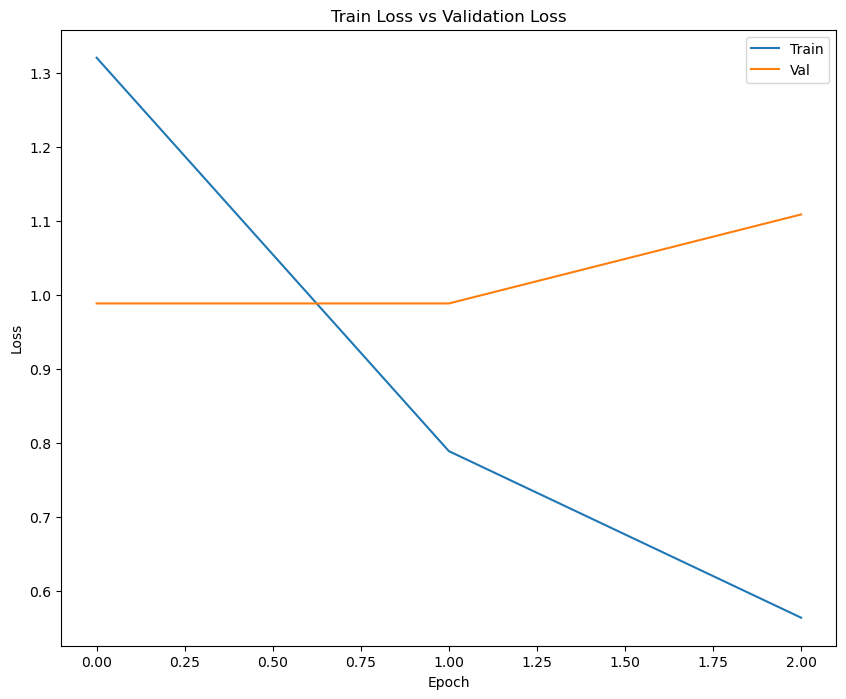

In [6]:
# Plotting train loss vs validation loss

fig, ax = plt.subplots(1, 1, figsize = (10, 8))
plot1 = ax.plot([1.3207243533575372, 0.7892483951273846, 0.5642413372721642])
plot2 = ax.plot([0.9887889303075383, 0.9887889303075383, 1.1090259188645253])
ax.set_title('Train Loss vs Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(('Train', 'Val'), loc = 'upper right')

## Testing the fine-tuned BERT base model

In [3]:
model = torch.load('/kaggle/input/output-files/finetunedmodel', map_location = torch.device('cpu'))
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [9]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# stop_words = set(stopwords.words('english'))

def preprocess(message):
    message = message.lower()
    punct = set(string.punctuation)
    list_of_words = [i for i in message if i not in punct]
    message = "".join(list_of_words)
    articles = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    message = re.sub(articles, " ", message)
    message = " ".join(message.split())
    return message
#     message_temp = []
#     for i in message.split():
#         if i not in stop_words:
#             message_temp.append(i)
#     return "".join(message_temp)

def return_answer(paragraph, question):
    inputs = tokenizer.encode_plus(question, paragraph, return_tensors = 'pt')
    outputs = model(**inputs)
    start_idx = torch.argmax(outputs[0])
    end_idx = torch.argmax(outputs[1])
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][start_idx: end_idx])
    predicted_answer = tokenizer.convert_tokens_to_string(tokens)
    return predicted_answer

def calculate_f1(pred, y):
    list_y = preprocess(y).split()
    list_pred = preprocess(pred).split()
    common = set(list_y) & set(list_pred)
    if len(common) == 0:
        return 0
    
    precision = len(common)/len(list_pred)
    recall = len(common)/len(list_y)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def predict_answer(context, question, true_answer):
    predicted_answer = return_answer(context, question)
    f1 = calculate_f1(predicted_answer, true_answer)
    print("Question:", question)
    print("Predicted Answer:", predicted_answer)
    print("True Answer:", true_answer)
    print("F1:", f1)

In [10]:
context = """ Harry Potter is a series of seven fantasy novels written by British author, J. K. Rowling. The novels chronicle the lives of a young wizard, 
              Harry Potter, and his friends Hermione Granger and Ron Weasley, all of whom are students at Hogwarts School of Witchcraft and Wizardry. 
              The main story arc concerns Harry's struggle against Lord Voldemort, a dark wizard who intends to become immortal, overthrow the wizard 
              governing body known as the Ministry of Magic and subjugate all wizards and Muggles (non-magical people). Since the release of the first novel, 
              Harry Potter and the Philosopher's Stone, on 26 June 1997, the books have found immense popularity, positive reviews, and commercial success worldwide. 
              They have attracted a wide adult audience as well as younger readers and are often considered cornerstones of modern young adult literature.[2] 
              As of February 2018, the books have sold more than 500 million copies worldwide, making them the best-selling book series in history, and have been translated 
              into eighty languages.[3] The last four books consecutively set records as the fastest-selling books in history, with the final installment selling roughly 
              eleven million copies in the United States within twenty-four hours of its release.  """

queries = [
           "Who wrote Harry Potter's novels?",
           "Who are Harry Potter's friends?",
           "Who is the enemy of Harry Potter?",
           "What are Muggles?",
           "Which is the name of Harry Poter's first novel?",
           "When did the first novel release?",
           "Who was attracted by Harry Potter novels?",
           "How many languages Harry Potter has been translated into? "
          ]
answers = [
           "J. K. Rowling",
           "Hermione Granger and Ron Weasley",
           "Lord Voldemort",
           "non-magical people",
           "Harry Potter and the Philosopher's Stone",
           "26 June 1997",
           "a wide adult audience as well as younger readers",
           "eighty"
          ]

for question, answer in zip(queries,answers):
    print("\n")
    predict_answer(context, question, answer)



Question: Who wrote Harry Potter's novels?
Predicted Answer: j. k. rowling
True Answer: J. K. Rowling
F1: 1.0


Question: Who are Harry Potter's friends?
Predicted Answer: hermione granger and ron weasley
True Answer: Hermione Granger and Ron Weasley
F1: 1.0


Question: Who is the enemy of Harry Potter?
Predicted Answer: 
True Answer: Lord Voldemort
F1: 0


Question: What are Muggles?
Predicted Answer: fantasy
True Answer: non-magical people
F1: 0


Question: Which is the name of Harry Poter's first novel?
Predicted Answer: harry potter and the philosopher ' s stone
True Answer: Harry Potter and the Philosopher's Stone
F1: 0.7272727272727272


Question: When did the first novel release?
Predicted Answer: 26 june 1997
True Answer: 26 June 1997
F1: 1.0


Question: Who was attracted by Harry Potter novels?
Predicted Answer: j. k. rowling
True Answer: a wide adult audience as well as younger readers
F1: 0


Question: How many languages Harry Potter has been translated into? 
Predicted An

In [17]:
# Experimenting with configurations

config = BertConfig.from_pretrained('bert-base-uncased')
config.num_hidden_layers = 6
config.hidden_dropout_prob = 0.2
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased', config = config).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['bert.encoder.layer.9.attention.self.key.weight', 'bert.encoder.layer.9.intermediate.dense.bias', 'bert.encoder.layer.7.output.LayerNorm.weight', 'bert.encoder.layer.10.intermediate.dense.weight', 'bert.encoder.layer.11.attention.self.key.weight', 'bert.encoder.layer.11.attention.output.dense.weight', 'bert.encoder.layer.7.attention.self.value.weight', 'bert.encoder.layer.8.attention.self.query.bias', 'bert.encoder.layer.8.output.dense.bias', 'bert.encoder.layer.8.output.dense.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.weight', 'bert.encoder.layer.9.attention.output.dense.weight', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.9.intermediate.dense.weight', 'bert.encoder.layer.10.output.LayerNorm.weight', 'bert.encoder.layer.10.attention.output.LayerNorm.bias', 'bert.encoder.layer.6.attention.self.value.bias', 'bert.encoder.layer.7.

In [18]:
optimizer = AdamW(model.parameters(), lr = 3e-5)
epochs = 3

# Implementing BERT variation-2

train_losses_v1 = []
valid_losses_v1 = []

for i in range(epochs):
  model.train()
  print('\n----------------------EPOCH {0}----------------------------'.format(i + 1))
  print('Training on SQuAD dataset for epoch {0}'.format(i + 1))
  train_loss = 0
  for idx, batch in enumerate(pytorch_train):
    if (idx + 1) % 1000 == 0:
      print('Batch {0}/{1}....'.format(idx + 1, len(pytorch_train)))
    
    batch_inputs = batch['input_ids'].to(device)
    mask = batch['attention_mask'].to(device)
    start_indices, end_indices = batch['start_index'].to(device), batch['end_index'].to(device)
    optimizer.zero_grad()
    output = model(batch_inputs, attention_mask = mask, start_positions = start_indices, end_positions = end_indices)
    batch_loss = output[0]
    batch_loss.backward()
    optimizer.step()
    train_loss += batch_loss.item()
  
  train_loss = train_loss/len(pytorch_train)
  model.eval()
  print('\nValidating on SQuAD dataset for epoch {0}'.format(i + 1))
  valid_loss = 0
  for idx, batch in enumerate(pytorch_valid):
    if (idx + 1) % 1000 == 0:
      print('Batch {0}/{1}...'.format(idx + 1, len(pytorch_valid)))
    
    with torch.no_grad():
      batch_inputs = batch['input_ids'].to(device)
      mask = batch['attention_mask'].to(device)
      start_indices, end_indices = batch['start_index'].to(device), batch['end_index'].to(device)
      output = model(batch_inputs, attention_mask = mask, start_positions = start_indices, end_positions = end_indices)
      batch_loss = output[0]
      valid_loss += batch_loss.item()
  
  valid_loss = valid_loss/len(pytorch_valid)
  train_losses_v1.append(train_loss)
  valid_losses_v1.append(valid_loss)

  print('\nEnd of epoch {0}'.format(i + 1))
  print('Train Loss:', train_loss)
  print('Validation Loss:', valid_loss)


----------------------EPOCH 1----------------------------
Training on SQuAD dataset for epoch 1
Batch 1000/10950....
Batch 2000/10950....
Batch 3000/10950....
Batch 4000/10950....
Batch 5000/10950....
Batch 6000/10950....
Batch 7000/10950....
Batch 8000/10950....
Batch 9000/10950....
Batch 10000/10950....

Validating on SQuAD dataset for epoch 1
Batch 1000/1322...

End of epoch 1
Train Loss: 1.6745575607693903
Validation Loss: 1.1944008452392292

----------------------EPOCH 2----------------------------
Training on SQuAD dataset for epoch 2
Batch 1000/10950....
Batch 2000/10950....
Batch 3000/10950....
Batch 4000/10950....
Batch 5000/10950....
Batch 6000/10950....
Batch 7000/10950....
Batch 8000/10950....
Batch 9000/10950....
Batch 10000/10950....

Validating on SQuAD dataset for epoch 2
Batch 1000/1322...

End of epoch 2
Train Loss: 1.0662110485272593
Validation Loss: 1.1491234377928292

----------------------EPOCH 3----------------------------
Training on SQuAD dataset for epoch 3
B

In [16]:
# Save model

torch.save(model,"finetunedmodel_trail2.h5")

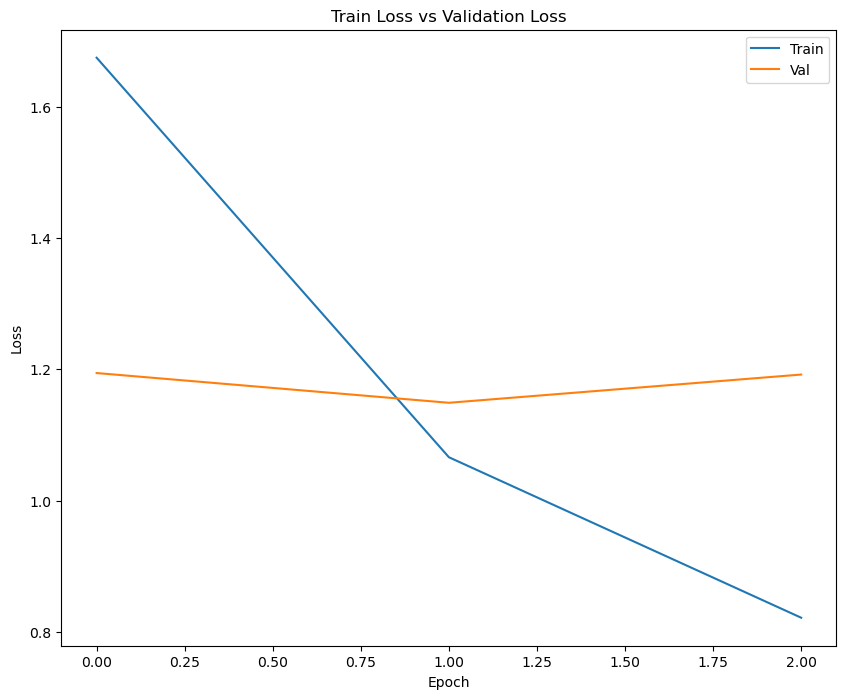

In [15]:
# Plotting train loss vs validation loss

fig, ax = plt.subplots(1, 1, figsize = (10, 8))
plot1 = ax.plot([1.6745575607693903, 1.0662110485272593, 0.8218302198570885])
plot2 = ax.plot([1.1944008452392292, 1.1491234377928292, 1.1921097667050884])
ax.set_title('Train Loss vs Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(('Train', 'Val'), loc = 'upper right')

In [22]:
model = torch.load('/kaggle/input/finetunedmodeltwo/finetunedmodeltwo', map_location = torch.device('cpu'))
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [23]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def preprocess(message):
    message = message.lower()
    punct = set(string.punctuation)
    list_of_words = [i for i in message if i not in punct]
    message = "".join(list_of_words)
    articles = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    message = re.sub(articles, " ", message)
    message = " ".join(message.split())
    return message

def return_answer(paragraph, question):
    inputs = tokenizer.encode_plus(question, paragraph, return_tensors = 'pt')
    outputs = model(**inputs)
    start_idx = torch.argmax(outputs[0])
    end_idx = torch.argmax(outputs[1])
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][start_idx: end_idx])
    predicted_answer = tokenizer.convert_tokens_to_string(tokens)
    return predicted_answer

def calculate_f1(pred, y):
    list_y = preprocess(y).split()
    list_pred = preprocess(pred).split()
    common = set(list_y) & set(list_pred)
    if len(common) == 0:
        return 0
    
    precision = len(common)/len(list_pred)
    recall = len(common)/len(list_y)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def predict_answer(context, question, true_answer):
    predicted_answer = return_answer(context, question)
    f1 = calculate_f1(predicted_answer, true_answer)
    print("Question:", question)
    print("Predicted Answer:", predicted_answer)
    print("True Answer:", true_answer)
    print("F1:", f1)

In [24]:
context = """ Harry Potter is a series of seven fantasy novels written by British author, J. K. Rowling. The novels chronicle the lives of a young wizard, 
              Harry Potter, and his friends Hermione Granger and Ron Weasley, all of whom are students at Hogwarts School of Witchcraft and Wizardry. 
              The main story arc concerns Harry's struggle against Lord Voldemort, a dark wizard who intends to become immortal, overthrow the wizard 
              governing body known as the Ministry of Magic and subjugate all wizards and Muggles (non-magical people). Since the release of the first novel, 
              Harry Potter and the Philosopher's Stone, on 26 June 1997, the books have found immense popularity, positive reviews, and commercial success worldwide. 
              They have attracted a wide adult audience as well as younger readers and are often considered cornerstones of modern young adult literature.[2] 
              As of February 2018, the books have sold more than 500 million copies worldwide, making them the best-selling book series in history, and have been translated 
              into eighty languages.[3] The last four books consecutively set records as the fastest-selling books in history, with the final installment selling roughly 
              eleven million copies in the United States within twenty-four hours of its release.  """

queries = [
           "Who wrote Harry Potter's novels?",
           "Who are Harry Potter's friends?",
           "Who is the enemy of Harry Potter?",
           "What are Muggles?",
           "Which is the name of Harry Poter's first novel?",
           "When did the first novel release?",
           "Who was attracted by Harry Potter novels?",
           "How many languages Harry Potter has been translated into? "
          ]
answers = [
           "J. K. Rowling",
           "Hermione Granger and Ron Weasley",
           "Lord Voldemort",
           "non-magical people",
           "Harry Potter and the Philosopher's Stone",
           "26 June 1997",
           "a wide adult audience as well as younger readers",
           "eighty"
          ]

for question, answer in zip(queries,answers):
    print("\n")
    predict_answer(context, question, answer)



Question: Who wrote Harry Potter's novels?
Predicted Answer: j. k. rowling
True Answer: J. K. Rowling
F1: 1.0


Question: Who are Harry Potter's friends?
Predicted Answer: hermione granger and ron weasley
True Answer: Hermione Granger and Ron Weasley
F1: 1.0


Question: Who is the enemy of Harry Potter?
Predicted Answer: j. k. rowling. the novels chronicle the lives of a young wizard
True Answer: Lord Voldemort
F1: 0


Question: What are Muggles?
Predicted Answer: the lives of a young wizard, harry potter, and his friends hermione granger and ron weasley, all of whom are students at hogwarts school of witchcraft and wizardry. the main story arc concerns harry ' s struggle against lord voldemort, a dark wizard who intends to become immortal, overthrow the wizard governing body known as the ministry of magic and subjugate all wizards and muggles ( non - magical people
True Answer: non-magical people
F1: 0.031746031746031744


Question: Which is the name of Harry Poter's first novel?
Pr

# Implementing BERT large

In [9]:
# Using existing BERT model(24 transformer layers, 1024 hidden units, and 16 self-attention heads)

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12,

In [10]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

def preprocess(message):
    message = message.lower()
    punct = set(string.punctuation)
    list_of_words = [i for i in message if i not in punct]
    message = "".join(list_of_words)
    articles = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    message = re.sub(articles, " ", message)
    message = " ".join(message.split())
    return message

def return_answer(paragraph, question):
    inputs = tokenizer.encode_plus(question, paragraph, return_tensors = 'pt')
    outputs = model(**inputs)
    start_idx = torch.argmax(outputs[0])
    end_idx = torch.argmax(outputs[1])
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][start_idx: end_idx])
    predicted_answer = tokenizer.convert_tokens_to_string(tokens)
    return predicted_answer

def calculate_f1(pred, y):
    list_y = preprocess(y).split()
    list_pred = preprocess(pred).split()
    common = set(list_y) & set(list_pred)
    if len(common) == 0:
        return 0
    
    precision = len(common)/len(list_pred)
    recall = len(common)/len(list_y)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def predict_answer(context, question, true_answer):
    predicted_answer = return_answer(context, question)
    f1 = calculate_f1(predicted_answer, true_answer)
    print("Question:", question)
    print("Predicted Answer:", predicted_answer)
    print("True Answer:", true_answer)
    print("F1:", f1)

In [11]:
context = """ Harry Potter is a series of seven fantasy novels written by British author, J. K. Rowling. The novels chronicle the lives of a young wizard, 
              Harry Potter, and his friends Hermione Granger and Ron Weasley, all of whom are students at Hogwarts School of Witchcraft and Wizardry. 
              The main story arc concerns Harry's struggle against Lord Voldemort, a dark wizard who intends to become immortal, overthrow the wizard 
              governing body known as the Ministry of Magic and subjugate all wizards and Muggles (non-magical people). Since the release of the first novel, 
              Harry Potter and the Philosopher's Stone, on 26 June 1997, the books have found immense popularity, positive reviews, and commercial success worldwide. 
              They have attracted a wide adult audience as well as younger readers and are often considered cornerstones of modern young adult literature.[2] 
              As of February 2018, the books have sold more than 500 million copies worldwide, making them the best-selling book series in history, and have been translated 
              into eighty languages.[3] The last four books consecutively set records as the fastest-selling books in history, with the final installment selling roughly 
              eleven million copies in the United States within twenty-four hours of its release.  """

queries = [
           "Who wrote Harry Potter's novels?",
           "Who are Harry Potter's friends?",
           "Who is the enemy of Harry Potter?",
           "What are Muggles?",
           "Which is the name of Harry Poter's first novel?",
           "When did the first novel release?",
           "Who was attracted by Harry Potter novels?",
           "How many languages Harry Potter has been translated into? "
          ]
answers = [
           "J. K. Rowling",
           "Hermione Granger and Ron Weasley",
           "Lord Voldemort",
           "non-magical people",
           "Harry Potter and the Philosopher's Stone",
           "26 June 1997",
           "a wide adult audience as well as younger readers",
           "eighty"
          ]

for question, answer in zip(queries,answers):
    print("\n")
    predict_answer(context, question, answer)



Question: Who wrote Harry Potter's novels?
Predicted Answer: j. k. row
True Answer: J. K. Rowling
F1: 0.6666666666666666


Question: Who are Harry Potter's friends?
Predicted Answer: hermione granger and ron weas
True Answer: Hermione Granger and Ron Weasley
F1: 0.8000000000000002


Question: Who is the enemy of Harry Potter?
Predicted Answer: lord voldemo
True Answer: Lord Voldemort
F1: 0.5


Question: What are Muggles?
Predicted Answer: non - magical
True Answer: non-magical people
F1: 0


Question: Which is the name of Harry Poter's first novel?
Predicted Answer: harry potter and the philosopher ' s
True Answer: Harry Potter and the Philosopher's Stone
F1: 0.6


Question: When did the first novel release?
Predicted Answer: 26 june
True Answer: 26 June 1997
F1: 0.8


Question: Who was attracted by Harry Potter novels?
Predicted Answer: wide adult audience as well as younger
True Answer: a wide adult audience as well as younger readers
F1: 0.7999999999999999


Question: How many lan